Here's a `SurfaceCode` class, based on the `RepetitionCode` class.

Though it its mostly written to be general, some parts are hard-coded for `d=3`.

Only `0` and `1` logical states currently supported, and the results from the non-relevant stabilizers are ignored. This is done to make the code compatible with the current `GraphDecoder` in Ignis.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

class SurfaceCode():
    
    def __init__(self,d,T,basis='z'):
        
        self.d = d
        self.T = 0
        self.basis = basis
        
        self._num_pv = int((d**2 - 1)/2)
        
        # quantum registers
        self.code_qubit = QuantumRegister(d**2, 'code_qubit')
        self.plaquette_qubit = QuantumRegister(self._num_pv, 'plaquette_qubit')
        self.vertex_qubit = QuantumRegister(self._num_pv, 'vertex_qubit')
        self.qubit_registers = [self.code_qubit,self.plaquette_qubit,self.vertex_qubit]
        
        # classical registers
        self.plaquette_bits = []
        self.vertex_bits = []
        self.code_bit = ClassicalRegister(d**2, 'code_bit')

        # create the circuits
        self.circuit = {}
        for log in ['0', '1']:
            self.circuit[log] = QuantumCircuit(
                self.code_qubit,self.plaquette_qubit,self.vertex_qubit,
                name=log)
            
        # apply initial logical paulis for encoded states
        self._preparation()

        # add the gates required for syndrome measurements
        for _ in range(T-1):
            self.syndrome_measurement()
        if T != 0:
            self.syndrome_measurement(reset=False)
            self.readout()

    def _preparation(self):
        """
        Prepares logical bit states by applying an x to the circuit that will
        encode a 1.
        """
        if self.basis=='z':
            self.x(['1'])
        else:
            for log in self.circuit:
                self.circuit[log].h(self.code_qubit)
            self.z(['1'])
        
    def get_circuit_list(self):
        """
        Returns:
            circuit_list: self.circuit as a list, with
            circuit_list[0] = circuit['0']
            circuit_list[1] = circuit['1']
            circuit_list[2] = circuit['+']
            circuit_list[3] = circuit['-']
        """
        circuit_list = [self.circuit[log] for j,log in enumerate(['0', '1'])]
        return circuit_list

    def x(self, logs=('0', '1'), barrier=False):
        """
        Applies a logical x to the circuits for the given logical values.
        Args:
            logs (list or tuple): List or tuple of logical values expressed as
                strings.
            barrier (bool): Boolean denoting whether to include a barrier at
                the end.
        """
        for log in logs:
            for j in range(self.d):
                self.circuit[log].x(self.code_qubit[j*d])
            if barrier:
                self.circuit[log].barrier()
       
    def z(self, logs=('0', '1'), barrier=False):
        """
        Applies a logical z to the circuits for the given logical values.
        Args:
            logs (list or tuple): List or tuple of logical values expressed as
                strings.
            barrier (bool): Boolean denoting whether to include a barrier at
                the end.
        """
        for log in logs:
            for j in range(self.d):
                self.circuit[log].z(self.code_qubit[j])
            if barrier:
                self.circuit[log].barrier()

    def syndrome_measurement(self, reset=True, barrier=False):
        """
        Application of a syndrome measurement round.
        Args:
            reset (bool): If set to true add a boolean at the end of each round
            barrier (bool): Boolean denoting whether to include a barrier at the end.
            
        """
        
        num_bits = int((self.d**2 - 1)/2)
        
        # classical registers for this round
        self.plaquette_bits.append(ClassicalRegister(
            self._num_pv, 'round_' + str(self.T) + '_plaquette_bit'))
        self.vertex_bits.append(ClassicalRegister(
            self._num_pv, 'round_' + str(self.T) + '_vertex_bit'))

        for log in ['0', '1']:

            self.circuit[log].add_register(self.plaquette_bits[-1])
            self.circuit[log].add_register(self.vertex_bits[-1])
            
            """
            The following gates are hard coded for the d=3 case
                 ------ 
                |X v0 X|
                0------1------2--           b------a        
                |Z    Z|X    X|Z |          |      |
                |  p0  |  v1  | p1|         |  v   |
                |Z    Z|X    X|Z |          |      |
              --3------4------5--           d------c
             |Z |X    X|Z    Z|
            |p2 |  v2  |  p3  |             c------a 
             |Z |X    X|Z    Z|             |      |
              --6------7------8             |  p   |
                       |X v3 X|             |      |
                        ------              d------b 
            """
            
            self.circuit[log].h(self.vertex_qubit[0])
            self.circuit[log].h(self.vertex_qubit[1])
            self.circuit[log].h(self.vertex_qubit[2])
            self.circuit[log].h(self.vertex_qubit[3])
            
            self.circuit[log].cx(self.code_qubit[1], self.plaquette_qubit[0])
            self.circuit[log].cx(self.code_qubit[3], self.plaquette_qubit[2])
            self.circuit[log].cx(self.code_qubit[5], self.plaquette_qubit[3])
                        
            self.circuit[log].cx(self.vertex_qubit[1],self.code_qubit[2])
            self.circuit[log].cx(self.vertex_qubit[2],self.code_qubit[4])
            self.circuit[log].cx(self.vertex_qubit[3],self.code_qubit[8])
            
            self.circuit[log].cx(self.code_qubit[4], self.plaquette_qubit[0])
            self.circuit[log].cx(self.code_qubit[6], self.plaquette_qubit[2])
            self.circuit[log].cx(self.code_qubit[8], self.plaquette_qubit[3])
            
            self.circuit[log].cx(self.vertex_qubit[1],self.code_qubit[1])
            self.circuit[log].cx(self.vertex_qubit[2],self.code_qubit[3])
            self.circuit[log].cx(self.vertex_qubit[3],self.code_qubit[7])
            
            self.circuit[log].cx(self.code_qubit[0], self.plaquette_qubit[0])
            self.circuit[log].cx(self.code_qubit[2], self.plaquette_qubit[1])
            self.circuit[log].cx(self.code_qubit[4], self.plaquette_qubit[3])
            
            self.circuit[log].cx(self.vertex_qubit[0],self.code_qubit[1])
            self.circuit[log].cx(self.vertex_qubit[1],self.code_qubit[5])
            self.circuit[log].cx(self.vertex_qubit[2],self.code_qubit[7])
            
            self.circuit[log].cx(self.code_qubit[3], self.plaquette_qubit[0])
            self.circuit[log].cx(self.code_qubit[5], self.plaquette_qubit[1])
            self.circuit[log].cx(self.code_qubit[7], self.plaquette_qubit[3])
            
            self.circuit[log].cx(self.vertex_qubit[0],self.code_qubit[0])
            self.circuit[log].cx(self.vertex_qubit[1],self.code_qubit[4])
            self.circuit[log].cx(self.vertex_qubit[2],self.code_qubit[6])
            
            self.circuit[log].h(self.vertex_qubit[0])
            self.circuit[log].h(self.vertex_qubit[1])
            self.circuit[log].h(self.vertex_qubit[2])
            self.circuit[log].h(self.vertex_qubit[3])
            
            """
            Now we return to being general
            """
            
            for j in range(self._num_pv):
                self.circuit[log].measure(
                    self.vertex_qubit[j], self.vertex_bits[self.T][j])
                self.circuit[log].measure(
                    self.plaquette_qubit[j], self.plaquette_bits[self.T][j])
                if reset:
                    self.circuit[log].reset(self.vertex_qubit[j])
                    self.circuit[log].reset(self.plaquette_qubit[j])

            if barrier:
                self.circuit[log].barrier()

        self.T += 1
        
    def readout(self):
        """
        Readout of all code qubits, which corresponds to a logical measurement
        as well as allowing for a measurement of the syndrome to be inferred.
        """
        
        for log in ['0', '1']:
            if self.basis=='x':
                self.circuit[log].h(self.code_qubit)
            self.circuit[log].add_register(self.code_bit)
            self.circuit[log].measure(self.code_qubit, self.code_bit)
            
    def process_results(self, raw_results):
        
        results = {}
        for log in raw_results:
            results[log] = {}
            for string in raw_results[log]:
                
                final_readout = string.split(' ')[0][::-1]
                
                # get logical readout
                # (though it's called Z, it actually depends on the basis)
                Z = [0,0]
                for j in range(self.d):
                    if self.basis=='z':
                        # evaluated using top row
                        Z[0] = (Z[0] + int(final_readout[j]))%2
                        # evaluated using bottom row
                        Z[1] = (Z[1] + int(final_readout[self.d**2-1-j]))%2
                    else:
                        # evaluated using left side
                        Z[0] = (Z[0] + int(final_readout[j*self.d]))%2
                        # evaluated using right side
                        Z[1] = (Z[1] + int(final_readout[(j+1)*self.d-1]))%2  
                    
                measured_Z = str(Z[0]) + ' ' + str(Z[1])
                
                
                
                # final syndrome for plaquettes deduced from final code qubit readout
                
                """
                The following analysis is hard coded for the d=3 case
                     ------ 
                    |X v0 X|
                    0------1------2--
                    |Z    Z|X    X|Z |
                    |  p0  |  v1  | p1|
                    |Z    Z|X    X|Z |
                  --3------4------5--
                 |Z |X    X|Z    Z|
                |p2 |  v2  |  p3  |
                 |Z |X    X|Z    Z|
                  --6------7------8
                           |X v3 X|
                            ------
                """
                
                def get_plaquette(qubits):
                    plaquette = 0
                    for q in qubits:
                        plaquette = (plaquette + int(final_readout[q]))%2
                    return str(plaquette)
                
                if self.basis=='z':
                    full_syndrome = ''
                    full_syndrome += get_plaquette([4,5,7,8]) # p3
                    full_syndrome += get_plaquette([3,6]) # p2
                    full_syndrome += get_plaquette([2,5]) # p1
                    full_syndrome += get_plaquette([0,1,3,4]) # p0
                else:
                    full_syndrome = ''
                    full_syndrome += get_plaquette([7,8]) # v3
                    full_syndrome += get_plaquette([3,4,6,7]) # v2
                    full_syndrome += get_plaquette([1,2,4,5]) # v1
                    full_syndrome += get_plaquette([0,1]) # v0    
                
                """
                Now we return to being general
                """
                
                # results from all other plaquette syndrome measurements then added
                if self.basis=='z':
                    full_syndrome = full_syndrome + ' ' + ' '.join(string.split(' ')[2::2])
                else:
                    full_syndrome = full_syndrome + ' ' + ' '.join(string.split(' ')[1::2])

                # changes between one syndrome and the next then calculated
                syndrome_list = full_syndrome.split(' ')

                height = len(syndrome_list)
                width = len(syndrome_list[0])
                syndrome_changes = ''
                for t in range(height):
                    for j in range(width):
                        if t == 0:
                            change = (syndrome_list[-1][j] != '0')
                        else:
                            change = (syndrome_list[-t][j]
                                      != syndrome_list[-t - 1][j])
                        syndrome_changes += '0' * (not change) + '1' * change
                    syndrome_changes += ' '

                # the space separated string of syndrome changes then gets a
                # double space separated logical value on the end
                new_string = measured_Z + '  ' + syndrome_changes[:-1]
                
                results[log][new_string] = raw_results[log][string]
                
        return results                  

Let's set up a code. This contains circuits for logical `0` and logical `1`. If `basis='x'` is specified, these will actually correspond to logical `+` and `-`. Otherwise they are just `0` and `1`.

In [2]:
d = 3; T = 3
code = SurfaceCode(d,T,basis='x')

Now we set up the decoder. This runs a whole bunch of simulations to understand how errors affect the syndrome. So it'll take a little while.

In [3]:
from qiskit.ignis.verification.topological_codes import GraphDecoder

dec = GraphDecoder(code)

As a test we'll check that no single qubit error of any (Pauli) type, anywhere in the circuit, causes a logical error

In [4]:
import copy
from qiskit import Aer, execute


def test_single_qubit_errors(code,decoder):

    qc = code.circuit['0']
    
    blank_qc = QuantumCircuit()
    for qreg in qc.qregs:
        blank_qc.add_register(qreg)
    for creg in qc.cregs:
        blank_qc.add_register(creg)

    error_circuit = {}
    circuit_name = {}
    depth = len(qc)
    for j in range(depth):
        qubits = qc.data[j][1]
        for qubit in qubits:
            for error in ['x', 'y', 'z']:
                temp_qc = copy.deepcopy(blank_qc)
                temp_qc.name = str((j, qubit, error))
                temp_qc.data = qc.data[0:j]
                getattr(temp_qc, error)(qubit)
                temp_qc.data += qc.data[j:depth + 1]
                circuit_name[(j, qubit, error)] = temp_qc.name
                error_circuit[temp_qc.name] = temp_qc

    job = execute(list(error_circuit.values()), Aer.get_backend('qasm_simulator'), shots=1)

    for j in range(depth):
        qubits = qc.data[j][1]
        for qubit in qubits:
            for error in ['x', 'y', 'z']:

                raw_results = {}
                raw_results['0'] = job.result().get_counts(
                    str((j, qubit, error)))
                results = code.process_results(raw_results)

                if dec.get_logical_prob(results)['0']!=0:
                    print("\nError of type " + \
                          error + " on qubit " + str(qubit) + \
                          " at depth " + str(j) + " leads to a logical error.")
                    print(raw_results)
                    print(results)
                
test_single_qubit_errors(code,dec)

If nothing got printed, there is nothing to worry about!

Now let's do an actual error model.

In [5]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error, coherent_unitary_error

def get_pauli_noise(p_err):
    
    error_gate1 = pauli_error([('X', p_err/3), ('Y', p_err/3), ('Z', p_err/3), ('I', 1 - p_err)])
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

def get_field_noise(p_err):
    
    error_gate1 = pauli_error([('Z', p_err), ('I', 1 - p_err)])
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

def get_depolarizing_noise(p_err):
    
    error_gate1 = depolarizing_error(p_err, 1)
    error_gate2 = depolarizing_error(p_err*10, 2)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

## Try depolarizing noise

In [6]:
logical_probs_0 = []; logical_probs_1 = [];

import numpy as np
p_values = np.arange(1e-5, 1e-4, 1e-5)

for p in p_values:

    job = execute(code.get_circuit_list(), Aer.get_backend('qasm_simulator'), shots=2**15, 
                  noise_model=get_depolarizing_noise(p))

    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(int(log))

    results = code.process_results(raw_results)

    logical_prob_match = dec.get_logical_prob(results)

    print('\nFor error probability')
    print(p)
    print('Logical error probabilities are')
    print(logical_prob_match)
    logical_probs_0.append(logical_prob_match['0'])
    logical_probs_1.append(logical_prob_match['1'])


For error probability
1e-05
Logical error probabilities are
{'0': 0.005434782608695652, '1': 0.0}

For error probability
2e-05
Logical error probabilities are
{'0': 0.0, '1': 0.006211180124223602}

For error probability
3.0000000000000004e-05
Logical error probabilities are
{'0': 0.0, '1': 0.0}

For error probability
4e-05
Logical error probabilities are
{'0': 0.010416666666666666, '1': 0.010582010582010581}

For error probability
5e-05
Logical error probabilities are
{'0': 0.009900990099009901, '1': 0.005376344086021506}

For error probability
6e-05
Logical error probabilities are
{'0': 0.0, '1': 0.015625}

For error probability
7.000000000000001e-05
Logical error probabilities are
{'0': 0.02040816326530612, '1': 0.014634146341463415}

For error probability
8e-05
Logical error probabilities are
{'0': 0.015625, '1': 0.010810810810810811}

For error probability
9e-05
Logical error probabilities are
{'0': 0.03, '1': 0.03535353535353535}


<ipython-input-7-03025395da00>:5: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plotter.xscale("log", nonposx='clip')
<ipython-input-7-03025395da00>:6: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plotter.yscale("log", nonposy='clip')


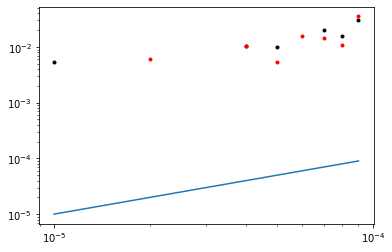

In [7]:
import matplotlib.pyplot as plotter
plotter.plot(p_values, logical_probs_0, 'k.')
plotter.plot(p_values, logical_probs_1, 'r.')
plotter.plot(p_values, p_values)
plotter.xscale("log", nonposx='clip')
plotter.yscale("log", nonposy='clip')

## Try Pauli noise

In [8]:
%precision 14

'%.14f'

In [ ]:
logical_probs_0 = []; logical_probs_1 = [];

import numpy as np
p_values = np.arange(1e-5, 1e-4, 1e-5)

for p in p_values:

    job = execute(code.get_circuit_list(), Aer.get_backend('qasm_simulator'), shots=2**19, 
                  noise_model=get_pauli_noise(p), backend_options={'precision': 'double', 'zero_threshold': 1e-15})

    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(int(log))

    results = code.process_results(raw_results)

    logical_prob_match = dec.get_logical_prob(results)

    print('\nFor error probability')
    print(p)
    print('Logical error probabilities are')
    print(logical_prob_match)
    logical_probs_0.append(logical_prob_match['0'])
    logical_probs_1.append(logical_prob_match['1'])

<ipython-input-9-62ffa77e14a4>:8: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.
  job = execute(code.get_circuit_list(), Aer.get_backend('qasm_simulator'), shots=2**19,



For error probability
1e-05
Logical error probabilities are
{'0': 0.0, '1': 0.0004878048780487805}


In [ ]:
import matplotlib.pyplot as plotter
plotter.plot(p_values, logical_probs_0, 'k.')
plotter.plot(p_values, logical_probs_1, 'r.')
plotter.plot(p_values, p_values)
plotter.xscale("log", nonposx='clip')
plotter.yscale("log", nonposy='clip')

## Try field noise

In [ ]:
logical_probs_0 = []; logical_probs_1 = [];

import numpy as np
p_values = np.arange(1e-5, 1e-4, 1e-5)

for p in p_values:

    job = execute(code.get_circuit_list(), Aer.get_backend('qasm_simulator'), shots=2**19,
                  noise_model=get_field_noise(p), backend_options={'precision': 'double', 'zero_threshold': 1e-15})

    raw_results = {}
    for log in ['0','1']:
        raw_results[log] = job.result().get_counts(int(log))

    results = code.process_results(raw_results)

    logical_prob_match = dec.get_logical_prob(results)

    print('\nFor error probability')
    print(p)
    print('Logical error probabilities are')
    print(logical_prob_match)
    logical_probs_0.append(logical_prob_match['0'])
    logical_probs_1.append(logical_prob_match['1'])

In [ ]:
import matplotlib.pyplot as plotter
plotter.plot(p_values, logical_probs_0, 'k.')
plotter.plot(p_values, logical_probs_1, 'r.')
plotter.plot(p_values, p_values)
plotter.xscale("log", nonposx='clip')
plotter.yscale("log", nonposy='clip')